In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.optim import Adam

### Options

In [46]:
pd.set_option("display.max_columns", None)
sns.set()

### Data Loading

In [2]:
url = "https://www.openml.org/data/download/22102255/dataset"
r = requests.get(url, allow_redirects=True)

In [3]:
with open("../data/csgo_round_winners_data.txt", "wb") as _file:
    _file.write(r.content)

In [7]:
data = list()

with open("../data/csgo_round_winners_data.txt", 'r') as _file:
    for line in _file.read().split("\n"):
        if line.startswith('@') or line.startswith('%') or line == "":
            continue
        data.append(line)

In [8]:
columns = list()

with open("../data/csgo_round_winners_data.txt", 'r') as _file:
    for line in _file.read().split("\n"):
        if line.startswith("@ATTRIBUTE"):
            columns.append(line.split(" ")[1])

In [11]:
with open("../data/csgo_round_winners.csv", "w") as _file:
    _file.write(",".join(columns))
    _file.write("\n")
    _file.write("\n".join(data))

### Data Preparation

In [38]:
df = pd.read_csv("../data/csgo_round_winners.csv")

df["t_win"] = df.round_winner.astype("category").cat.codes
df = df.drop("round_winner", axis=1)

dummy_df = pd.get_dummies(df["map"], prefix="map")
df = pd.concat([df, dummy_df], axis=1)
df = df.drop("map", axis=1)
columns = df.columns.to_list()
df

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,t_win,map_de_cache,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
0,175.00,0.0,0.0,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,True,False,False,False,False,False,False
1,156.03,0.0,0.0,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,True,False,False,False,False,False,False
2,96.03,0.0,0.0,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,True,False,False,False,False,False,False
3,76.03,0.0,0.0,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,True,False,False,False,False,False,False
4,174.97,1.0,0.0,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [40]:
correlations = df[columns].corr()
correlations["t_win"].apply(abs).sort_values(ascending=False).iloc[:25]

t_win                           1.000000
ct_armor                        0.336382
ct_helmets                      0.308255
t_helmets                       0.297458
ct_defuse_kits                  0.291557
t_armor                         0.290753
ct_grenade_flashbang            0.253868
ct_players_alive                0.216798
ct_grenade_smokegrenade         0.209975
ct_weapon_awp                   0.198626
t_weapon_ak47                   0.194147
ct_health                       0.190662
bomb_planted                    0.187101
ct_weapon_m4a4                  0.178008
ct_grenade_hegrenade            0.168781
ct_grenade_incendiarygrenade    0.168517
ct_weapon_ak47                  0.166855
t_grenade_flashbang             0.166839
ct_weapon_sg553                 0.163963
t_weapon_sg553                  0.163709
ct_weapon_usps                  0.152893
t_weapon_awp                    0.149878
t_players_alive                 0.142518
t_grenade_smokegrenade          0.140348
t_weapon_usps   

In [43]:
selected_columns = list()

for col in columns:
    if abs(correlations[col]["t_win"]) > 0.15:
        selected_columns.append(col)

df_selected = df[selected_columns]
df_selected

,bomb_planted,ct_health,ct_armor,t_armor,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_awp,ct_weapon_m4a4,ct_weapon_sg553,t_weapon_sg553,ct_weapon_usps,ct_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_win
0,False,500.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0
1,False,500.0,400.0,300.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0
2,False,391.0,294.0,200.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0
3,False,391.0,294.0,200.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0
4,False,500.0,192.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,True,200.0,195.0,359.0,2.0,4.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,2.0,1.0,0.0,1
122406,False,500.0,95.0,175.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,1.0,2.0,1.0,0.0,1
122407,False,500.0,495.0,475.0,3.0,5.0,1.0,5.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,4.0,4.0,3.0,1.0,1
122408,False,500.0,495.0,475.0,3.0,5.0,1.0,5.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0,5.0,0.0,0.0,1


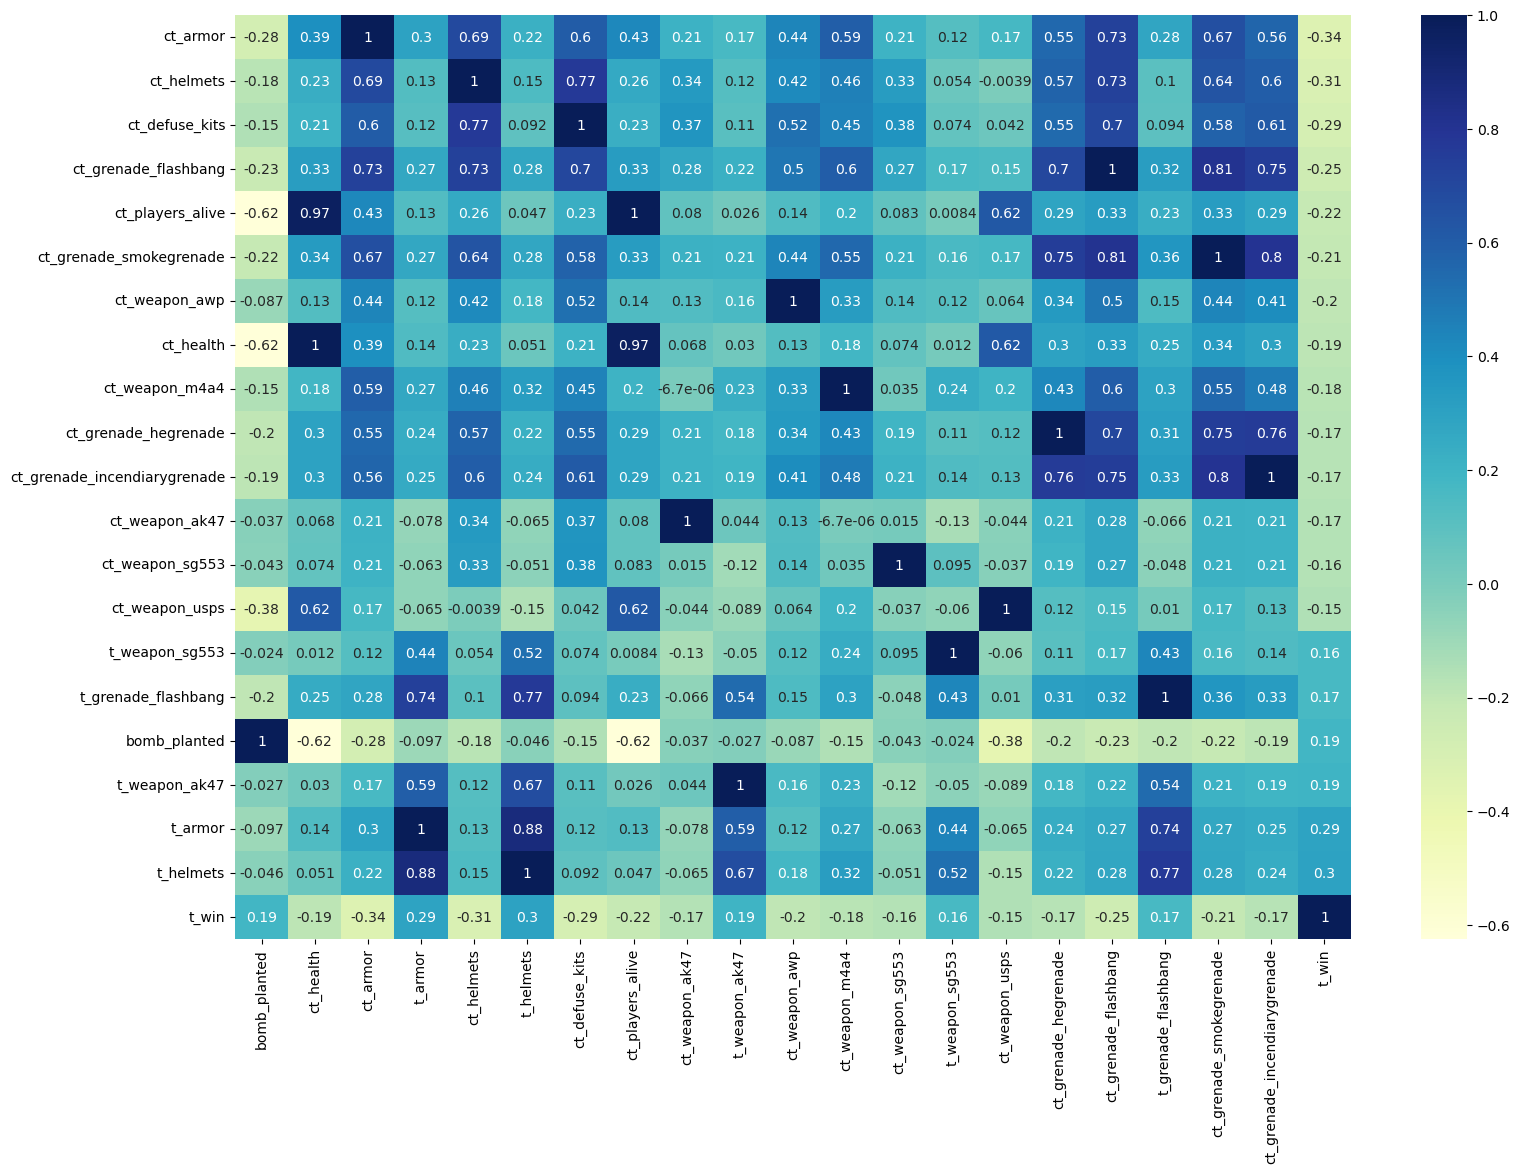

In [45]:
plt.figure(figsize=(18,12))
sns.heatmap(df_selected.corr().sort_values(by="t_win"), annot=True, cmap="YlGnBu")
plt.show()

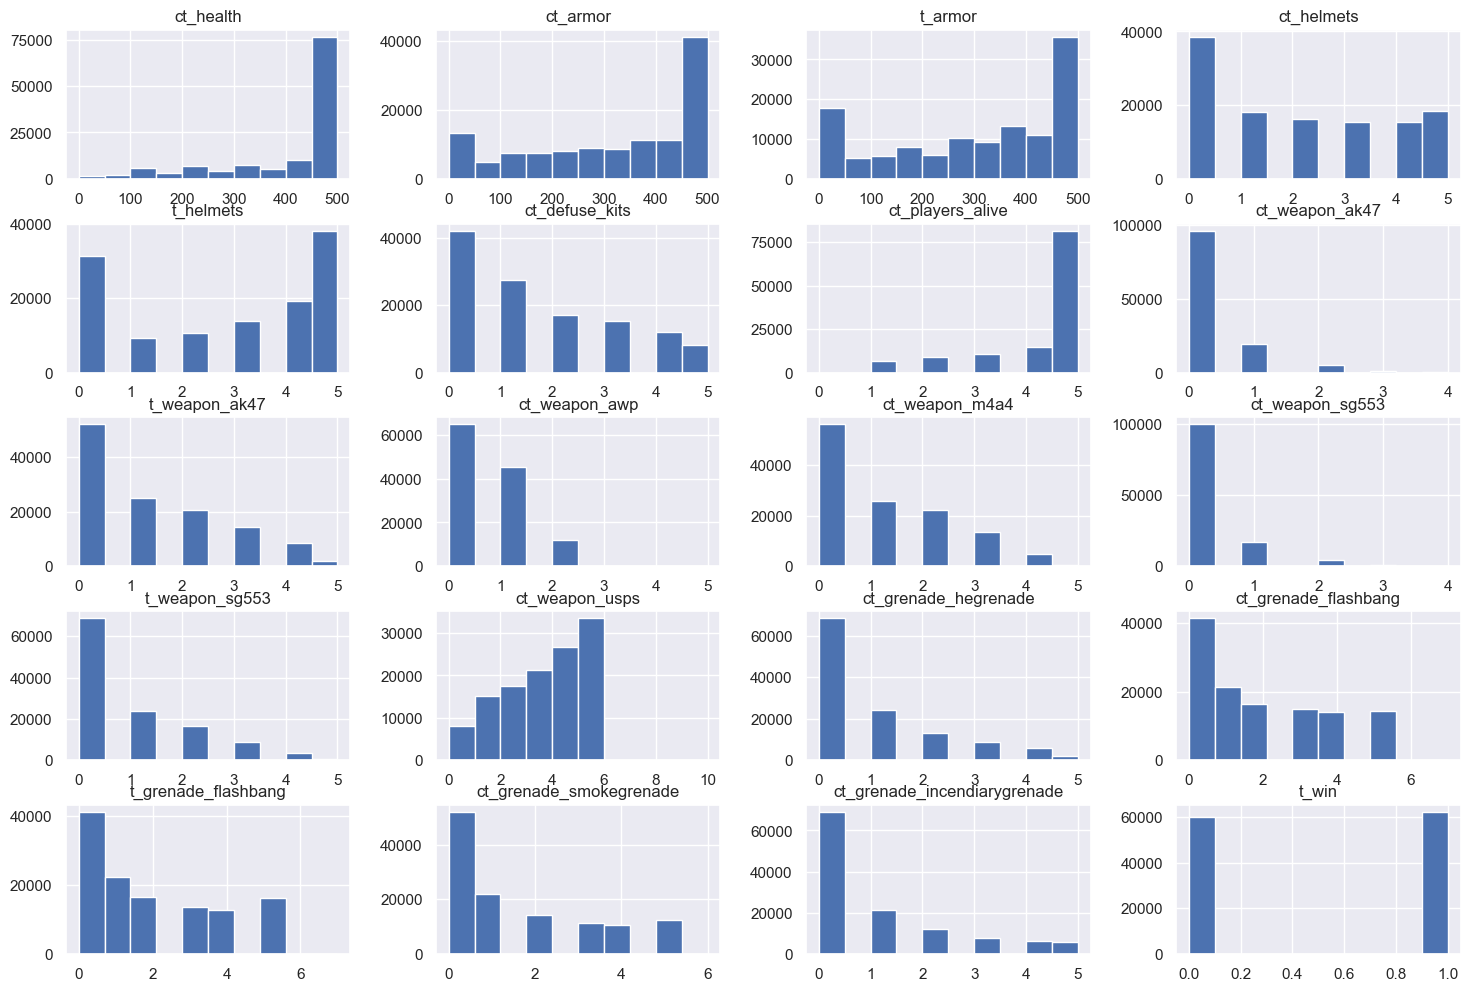

In [48]:
df_selected.hist(figsize=(18, 12))
plt.show()

In [50]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   bomb_planted                  122410 non-null  bool   
 1   ct_health                     122410 non-null  float64
 2   ct_armor                      122410 non-null  float64
 3   t_armor                       122410 non-null  float64
 4   ct_helmets                    122410 non-null  float64
 5   t_helmets                     122410 non-null  float64
 6   ct_defuse_kits                122410 non-null  float64
 7   ct_players_alive              122410 non-null  float64
 8   ct_weapon_ak47                122410 non-null  float64
 9   t_weapon_ak47                 122410 non-null  float64
 10  ct_weapon_awp                 122410 non-null  float64
 11  ct_weapon_m4a4                122410 non-null  float64
 12  ct_weapon_sg553               122410 non-nul

### Training

#### Approach 1: K-Neighbors Classifier

In [52]:
X, y = df_selected.drop(["t_win"], axis=1), df_selected["t_win"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [58]:
knn.score(X_test_scaled, y_test)

0.7656237235519974

In [61]:
param_grid = {
    "n_neighbors": list(range(5, 17, 2)),
    "weights": ["uniform", "distance"]
}

knn = KNeighborsClassifier(n_jobs=4)

clf = RandomizedSearchCV(knn, param_grid, n_jobs=4, n_iter=3, verbose=2, cv=3)
clf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=4), n_iter=3,
                   n_jobs=4,
                   param_distributions={'n_neighbors': [5, 7, 9, 11, 13, 15],
                                        'weights': ['uniform', 'distance']},
                   verbose=2)

In [63]:
knn = clf.best_estimator_
knn

KNeighborsClassifier(n_jobs=4, n_neighbors=13, weights='distance')

In [64]:
knn.score(X_test_scaled, y_test)

0.7803284045421126

#### Approach 2: Decision Trees/Random Forest

In [87]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

forest = RandomForestClassifier(n_jobs=4)

clf = GridSearchCV(forest, param_grid, cv=5, scoring="accuracy")
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=4),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [88]:
forest = clf.best_estimator_
forest

RandomForestClassifier(max_depth=30, n_estimators=200, n_jobs=4)

In [94]:
forest.score(X_test_scaled, y_test)

0.8295890858589985